# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [87]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from scipy.stats import ks_2samp

from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler

import statsmodels.formula.api as smf

In [88]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [91]:
def bivariada_analysis(dataframe, resposta, explicativa):
  
    # Agrupar os dados e calcular as estatísticas
    bivariada = dataframe.groupby(explicativa)[resposta].agg(
        saudaveis=lambda x: (x == 0).sum(),
        doentes=lambda x: (x == 1).sum(),
        total='count'
    ).reset_index()

    # Calcular quantidade média de doentes
    bivariada['qtd_media_doentes'] = bivariada['doentes'] / bivariada['total']

    # Calcular Odds
    bivariada['odds'] = bivariada['doentes'] / bivariada['saudaveis']

    # Calcular Odds Ratio (referência = Total)
    odds_total = dataframe[resposta].sum() / (len(dataframe) - dataframe[resposta].sum())
    bivariada['odds_ratio'] = bivariada['odds'] / odds_total

    # Calcular Logito (LOG(Odds))
    bivariada['logito'] = np.log(bivariada['odds'])

    # Calcular Weight of Evidence (WOE)
    bivariada['woe'] = np.log(bivariada['odds_ratio'])

    return bivariada

In [92]:
# Aplicar a análise bivariada para as variáveis qualitativas
bivariada_sex = bivariada_analysis(df, resposta='flag_doente', explicativa='sex')
bivariada_cp = bivariada_analysis(df, resposta='flag_doente', explicativa='cp')
bivariada_thal = bivariada_analysis(df, resposta='flag_doente', explicativa='thal')

# Exibir os resultados no console ou Jupyter Notebook
print("Bivariada - Variável 'sex':")
print(bivariada_sex)

print("\nBivariada - Variável 'cp':")
print(bivariada_cp)

print("\nBivariada - Variável 'thal':")
print(bivariada_thal)

Bivariada - Variável 'sex':
   sex  saudaveis  doentes  total  qtd_media_doentes      odds  odds_ratio  \
0  0.0         72       25     97           0.257732  0.347222    0.409672   
1  1.0         92      114    206           0.553398  1.239130    1.461996   

    logito       woe  
0 -1.05779 -0.892398  
1  0.21441  0.379802  

Bivariada - Variável 'cp':
    cp  saudaveis  doentes  total  qtd_media_doentes      odds  odds_ratio  \
0  1.0         16        7     23           0.304348  0.437500    0.516187   
1  2.0         41        9     50           0.180000  0.219512    0.258993   
2  3.0         68       18     86           0.209302  0.264706    0.312315   
3  4.0         39      105    144           0.729167  2.692308    3.176536   

     logito       woe  
0 -0.826679 -0.661286  
1 -1.516347 -1.350955  
2 -1.329136 -1.163743  
3  0.990399  1.155791  

Bivariada - Variável 'thal':
  thal  saudaveis  doentes  total  qtd_media_doentes      odds  odds_ratio  \
0  3.0        129    

A variável que parece discriminar mais o risco é ***thal***, com:

- Maior Odds Ratio (3.75 para thal=7), indicando um risco muito mais elevado nesse grupo.
- Maior quantidade média de doentes (76.1% para thal=7), sugerindo que ela é muito eficaz em separar os grupos de risco.

A variável cp também discrimina bem, mas não tanto quanto thal. A variável sex, apesar de apresentar discriminação, tem menos variação entre os grupos.

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [95]:
def bivariada_continua(dataframe, resposta, explicativa, n_grupos=5):
  
    # Categorizar a variável contínua em n_grupos usando pd.qcut
    dataframe[f'{explicativa}_group'] = pd.qcut(dataframe[explicativa], q=n_grupos, duplicates='drop')

    # Agrupar os dados e calcular as estatísticas
    bivariada = dataframe.groupby(f'{explicativa}_group', observed=False)[resposta].agg(
        saudaveis=lambda x: (x == 0).sum(),
        doentes=lambda x: (x == 1).sum(),
        total='count'
    ).reset_index()

    # Calcular quantidade média de doentes
    bivariada['qtd_media_doentes'] = bivariada['doentes'] / bivariada['total']

    # Calcular Odds
    bivariada['odds'] = bivariada['doentes'] / bivariada['saudaveis']

    # Calcular Odds Ratio (referência = Total)
    odds_total = dataframe[resposta].sum() / (len(dataframe) - dataframe[resposta].sum())
    bivariada['odds_ratio'] = bivariada['odds'] / odds_total

    # Calcular Logito (LOG(Odds))
    bivariada['logito'] = np.log(bivariada['odds'])

    # Calcular Weight of Evidence (WOE)
    bivariada['woe'] = np.log(bivariada['odds_ratio'])

    return bivariada


In [96]:
# Aplicar a análise bivariada para a variável age
bivariada_age = bivariada_continua(df, resposta='flag_doente', explicativa='age')

# Exibir os resultados
print(bivariada_age)

        age_group  saudaveis  doentes  total  qtd_media_doentes      odds  \
0  (28.999, 45.0]         47       16     63           0.253968  0.340426   
1    (45.0, 53.0]         42       22     64           0.343750  0.523810   
2    (53.0, 58.0]         32       39     71           0.549296  1.218750   
3    (58.0, 62.0]         13       32     45           0.711111  2.461538   
4    (62.0, 77.0]         30       30     60           0.500000  1.000000   

   odds_ratio    logito       woe  
0    0.401653 -1.077559 -0.912166  
1    0.618020 -0.646627 -0.481235  
2    1.437950  0.197826  0.363218  
3    2.904261  0.900787  1.066179  
4    1.179856  0.000000  0.165392  


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [98]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Preparação dos dados
# Certifique-se de que não haja valores ausentes nas variáveis selecionadas
df = df.dropna(subset=['sex', 'cp', 'trestbps', 'age', 'flag_doente'])

# Separar variáveis independentes (X) e dependente (y)
X = df[['sex', 'cp', 'trestbps', 'age']]
y = df['flag_doente']

# Dividir em conjunto de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Construir o modelo de regressão logística
model = LogisticRegression(max_iter=1000)  # Aumentar max_iter para evitar erros de convergência
model.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo
print("Matriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Exibir coeficientes do modelo
coeficientes = pd.DataFrame({'Variável': X.columns, 'Coeficiente': model.coef_[0]})
print("\nCoeficientes do Modelo:")
print(coeficientes)

Matriz de Confusão:
[[23  6]
 [ 8 24]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.74      0.79      0.77        29
           1       0.80      0.75      0.77        32

    accuracy                           0.77        61
   macro avg       0.77      0.77      0.77        61
weighted avg       0.77      0.77      0.77        61


Coeficientes do Modelo:
   Variável  Coeficiente
0       sex     1.608018
1        cp     0.980852
2  trestbps     0.019499
3       age     0.064057


### 1. Matriz de Confusão:
A matriz é:


[[23  6]
 [ 8 24]]
 
#### Linha 1 (Verdadeiros Negativos e Falsos Positivos):
- 23: Verdadeiros negativos (classificados corretamente como "não doentes").
- 6: Falsos positivos (classificados como "doentes", mas na verdade não são).
#### Linha 2 (Falsos Negativos e Verdadeiros Positivos):
- 8: Falsos negativos (classificados como "não doentes", mas na verdade são).
- 24: Verdadeiros positivos (classificados corretamente como "doentes").

### 2. Relatório de Classificação:
Métricas para as classes "0" (não doentes) e "1" (doentes):

***Precisão (Precision):***
- Classe 0: 74% dos indivíduos classificados como "não doentes" realmente não têm a doença.
- Classe 1: 80% dos indivíduos classificados como "doentes" realmente têm a doença.

***Recall:***
- Classe 0: 79% dos indivíduos "não doentes" foram corretamente identificados.
- Classe 1: 75% dos indivíduos "doentes" foram corretamente identificados.

***F1-Score:***
Uma média harmônica entre precisão e recall, equilibrando ambas as métricas.
Ambas as classes têm F1-scores de 77%.

***Acurácia Geral:***
O modelo tem uma acurácia de 77%, ou seja, classifica corretamente 77% de todas as observações.

### 3. Coeficientes do Modelo:
Os coeficientes do modelo indicam a influência de cada variável na probabilidade de ser "doente" (classe 1). Coeficientes positivos aumentam a probabilidade, enquanto negativos a reduzem.

***sex:***
Coeficiente: 1.608018
Ser do sexo masculino aumenta a chance de ser classificado como "doente" (classe 1). Um coeficiente alto indica que o sexo tem grande peso no modelo.

***cp (Tipo de dor no peito):***
Coeficiente: 0.980852
Diferentes tipos de dor no peito estão associados ao risco de doença cardíaca. Valores mais altos para cp aumentam a probabilidade de ser "doente".

***trestbps (Pressão arterial em repouso):***
Coeficiente: 0.019499
A pressão arterial tem uma influência positiva, mas pequena, na probabilidade de doença cardíaca. Isso indica que, embora a variável seja relevante, seu impacto é menos significativo em comparação com outras variáveis.

***age:***
Coeficiente: 0.064057
Idade tem um efeito positivo na probabilidade de ser "doente". Isso reflete o fato de que o risco de doença cardíaca aumenta com a idade.

#### Interpretação Geral:

Variável mais influente:

O ***sexo (sex)*** tem o maior coeficiente positivo, indicando que ser do sexo masculino aumenta significativamente o risco de doença cardíaca no modelo.

- Idade (age) e tipo de dor no peito (cp):
Ambas têm um impacto relevante, mas menos expressivo em comparação ao sexo.

- Pressão arterial (trestbps):
Tem o menor impacto entre as variáveis. Embora contribua, sua influência é limitada.

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo


Dados de Calibragem:
  prob_group  prob_predita_media  taxa_eventos  count
0         G1            0.156993      0.076923     13
1         G2            0.369526      0.333333     12
2         G3            0.518135      0.666667     12
3         G4            0.697638      0.833333     12
4         G5            0.821236      0.750000     12


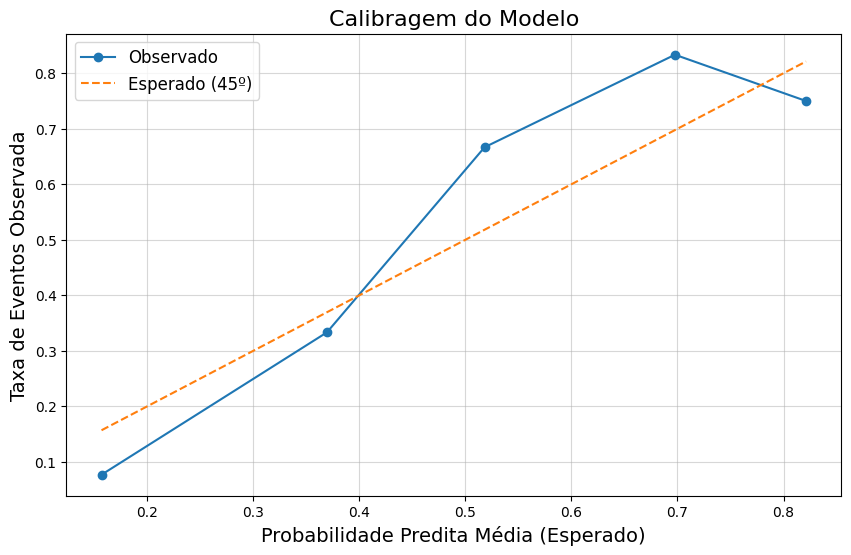

In [101]:
# Calcular as probabilidades preditas no conjunto de teste
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilidade da classe "1" (doentes)

# Adicionar as probabilidades preditas ao DataFrame de teste
test_data = X_test.copy()
test_data['flag_doente'] = y_test.values
test_data['prob_predita'] = y_pred_prob

# Categorizar as probabilidades em 5 grupos (quantis)
test_data['prob_group'] = pd.qcut(test_data['prob_predita'], q=5, labels=[f'G{i}' for i in range(1, 6)])

# Calcular as médias por grupo
calibration = test_data.groupby('prob_group', observed=False).agg(
    prob_predita_media=('prob_predita', 'mean'),
    taxa_eventos=('flag_doente', 'mean'),
    count=('flag_doente', 'count')
).reset_index()

# Visualizar os dados de calibragem
print("\nDados de Calibragem:")
print(calibration)

# Comparar graficamente esperado (prob_predita_media) versus observado (taxa_eventos)
plt.figure(figsize=(10, 6))
plt.plot(calibration['prob_predita_media'], calibration['taxa_eventos'], marker='o', label='Observado')
plt.plot(calibration['prob_predita_media'], calibration['prob_predita_media'], linestyle='--', label='Esperado (45º)')
plt.title('Calibragem do Modelo', fontsize=16)
plt.xlabel('Probabilidade Predita Média (Esperado)', fontsize=14)
plt.ylabel('Taxa de Eventos Observada', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [103]:
# Calcular acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy:.2f}")

Acurácia do modelo: 0.77


In [104]:
# Calcular AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC do Modelo: {auc:.2f}")

# Calcular GINI
gini = 2 * auc - 1
print(f"GINI do modelo: {gini:.2f}")

AUC do Modelo: 0.81
GINI do modelo: 0.62


In [105]:
# Separar probabilidades preditas pelas classes reais
prob_doentes = y_pred_prob[y_test == 1]
prob_nao_doentes = y_pred_prob[y_test == 0]

# Calcular KS
ks_stat, ks_p_value = ks_2samp(prob_doentes, prob_nao_doentes)
print(f"KS do modelo: {ks_stat:.2f}")

KS do modelo: 0.54


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [107]:
# Substituir valores '?' por NaN em todo o DataFrame
df.replace('?', np.nan, inplace=True)

# Converter colunas categóricas para numéricas
for col in categorical_vars:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Tratar valores ausentes (por exemplo, remover linhas com NaN)
df.dropna(subset=categorical_vars + [target], inplace=True)

# Teste qui-quadrado para variáveis categóricas
chi2_scores, p_values = chi2(df[categorical_vars], df[target])

# Exibir os resultados do teste qui-quadrado
categorical_importance = pd.DataFrame({
    'Variable': categorical_vars,
    'Chi2 Score': chi2_scores,
    'P-Value': p_values
}).sort_values(by='Chi2 Score', ascending=False)
print("\nImportância das Variáveis Categóricas:")
print(categorical_importance)

# Correlação para variáveis contínuas
continuous_importance = df[continuous_vars + [target]].corr()[target].drop(target).abs().sort_values(ascending=False)
print("\nImportância das Variáveis Contínuas (Correlação):")
print(continuous_importance)


Importância das Variáveis Categóricas:
  Variable  Chi2 Score       P-Value
6       ca   82.730613  9.403357e-20
7     thal   65.221093  6.694909e-16
4    exang   35.508090  2.539935e-09
1       cp   14.591587  1.335092e-04
3  restecg    8.134652  4.342718e-03
5    slope    7.828836  5.141921e-03
0      sex    7.444195  6.364137e-03
2      fbs    0.002547  9.597471e-01

Importância das Variáveis Contínuas (Correlação):
oldpeak     0.424052
thalach     0.423817
age         0.227075
trestbps    0.153490
chol        0.080285
Name: flag_doente, dtype: float64


In [125]:
# Selecionar as variáveis mais importantes
selected_vars = ['ca', 'thal', 'exang', 'cp', 'oldpeak', 'thalach', 'age']

# Separar os dados para o novo modelo
X = df[selected_vars]
y = df['flag_doente']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de regressão logística
model_improved = LogisticRegression(max_iter=1000)
model_improved.fit(X_train, y_train)

# Fazer previsões
y_pred = model_improved.predict(X_test)
y_pred_prob = model_improved.predict_proba(X_test)[:, 1]

# Avaliar o modelo
print("\nRelatório de Classificação - Modelo Melhorado:")
print(classification_report(y_test, y_pred))

# Matriz de confusão
print("\nMatriz de Confusão - Modelo Melhorado:")
print(confusion_matrix(y_test, y_pred))

# Calcular GINI e KS
auc_improved = roc_auc_score(y_test, y_pred_prob)
gini_improved = 2 * auc_improved - 1
ks_stat_improved, _ = ks_2samp(y_pred_prob[y_test == 1], y_pred_prob[y_test == 0])

print(f"\nAUC do Modelo Melhorado: {auc_improved:.2f}")
print(f"GINI do Modelo Melhorado: {gini_improved:.2f}")
print(f"KS do Modelo Melhorado: {ks_stat_improved:.2f}")


Relatório de Classificação - Modelo Melhorado:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        36
           1       0.88      0.88      0.88        24

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60


Matriz de Confusão - Modelo Melhorado:
[[33  3]
 [ 3 21]]

AUC do Modelo Melhorado: 0.96
GINI do Modelo Melhorado: 0.91
KS do Modelo Melhorado: 0.82



Dados de Calibragem:
  prob_group  prob_predita_media  taxa_eventos  count
0         G1            0.063673      0.000000     12
1         G2            0.139813      0.083333     12
2         G3            0.307558      0.166667     12
3         G4            0.712363      0.750000     12
4         G5            0.931635      1.000000     12


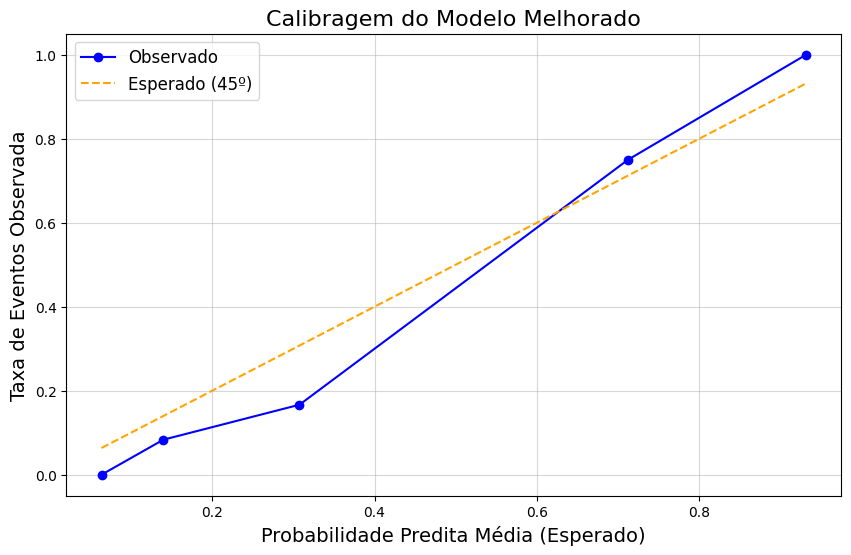

In [129]:
# Categorizar as probabilidades preditas em 5 grupos
X_test['prob_predita'] = y_pred_prob
X_test['flag_doente'] = y_test.values
X_test['prob_group'] = pd.qcut(X_test['prob_predita'], q=5, labels=[f'G{i}' for i in range(1, 6)])

# Calcular as médias por grupo
calibration = X_test.groupby('prob_group', observed=False).agg(
    prob_predita_media=('prob_predita', 'mean'),
    taxa_eventos=('flag_doente', 'mean'),
    count=('flag_doente', 'count')
).reset_index()

# Exibir os dados de calibragem
print("\nDados de Calibragem:")
print(calibration)

# Comparar graficamente esperado (prob_predita_media) versus observado (taxa_eventos)
plt.figure(figsize=(10, 6))
plt.plot(calibration['prob_predita_media'], calibration['taxa_eventos'], marker='o', label='Observado', color='blue')
plt.plot(calibration['prob_predita_media'], calibration['prob_predita_media'], linestyle='--', label='Esperado (45º)', color='orange')
plt.title('Calibragem do Modelo Melhorado', fontsize=16)
plt.xlabel('Probabilidade Predita Média (Esperado)', fontsize=14)
plt.ylabel('Taxa de Eventos Observada', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.5)
plt.show()

### 1. Relatório de Classificação

***Acurácia:***
- O modelo alcançou 90% de acurácia, uma melhora significativa em relação aos 77% do modelo anterior.

***Precisão:***
- Para a classe "0" (não doentes): 92% das previsões de "não doente" estão corretas.
- Para a classe "1" (doentes): 88% das previsões de "doente" estão corretas.

***Recall:***
- Para a classe "0" (não doentes): 92% dos indivíduos "não doentes" foram corretamente identificados.
- Para a classe "1" (doentes): 88% dos indivíduos "doentes" foram corretamente identificados.

***F1-Score:***
- Ambos os grupos têm um F1-Score alto, o que demonstra um bom equilíbrio entre precisão e recall.
- O modelo é eficiente tanto em identificar doentes quanto em evitar falsos positivos.

### 2. Matriz de Confusão

A matriz de confusão é:

[[33  3]
 [ 3 21]]

- ***Verdadeiros Negativos (33):*** Indivíduos "não doentes" corretamente classificados.
  
- ***Verdadeiros Positivos (21):*** Indivíduos "doentes" corretamente classificados.
  
- ***Falsos Positivos (3):*** Indivíduos classificados como "doentes", mas que não são.
  
- ***Falsos Negativos (3):*** Indivíduos classificados como "não doentes", mas que são.
  
A matriz mostra que o modelo tem uma baixa taxa de erros, com apenas 3 falsos positivos e 3 falsos negativos em um total de 60 exemplos.

### 3. Métricas de Discriminação

***AUC (Área Sob a Curva ROC):***

- O AUC de 0.96 é excelente. Indica que o modelo separa muito bem as classes "doente" e "não doente".
- AUC melhorou de 0.81 para 0.96

***GINI:***

- O GINI de 0.91 mostra uma discriminação muito alta, indicando que o modelo é altamente eficaz em diferenciar as classes.
- GINI melhorou de 0.62 para 0.91

***KS (Kolmogorov-Smirnov):***

- O KS de 0.82 é excelente. Um KS acima de 0.3 já é considerado bom, e 0.82 é um desempenho excepcional.
- KS melhorou de 0.54 para 0.82